#Introduction
In this project, we will build, train and evaluate a deep learning framework on a standard setting of Unsupervised Domain Adaptation (UDA).
Unsupervised Domain Adaptation is a learning framework to transfer knowledge learned from source domains with a large number of annotated training examples to target domains with unlabeled data only. In particular, for this project we will be using a UDA benchmark consisting of two datasets from Adaptiope which is a domain adaptation dataset with 123 classes in the three domains synthetic, product and real life. We'll be using 20 classes from both Product and Real Life datasets. Each one will play the role of the source and the target then we will conduct the same experiment in the other direction. As for the Unsupervised Domain Adaptation Technique, we'll be using a Discrepancy-based Method called [DeepCORAL](https://arxiv.org/pdf/1607.01719.pdf)

Let's begin by installing and importing the required libraries.

In [ ]:
#All the necessary installations and importings

#Preparing Dataset utilities
from google.colab import drive 
from zipfile import ZipFile
from torchvision.datasets import ImageFolder

#Pytorch utilities
import numpy as np
import statistics
from torch.utils.data import DataLoader
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as tt
from torch.utils.data import random_split
from tqdm.notebook import tqdm, tnrange
import pickle
from tabulate import tabulate

#Data vizualization utilities
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Preparing Source and Target Datasets
In this section, we will create functions to get our datasets ready, we will also make some data analysis to understand more the data we're dealing with.


##Extracting the dataset

We will begin by mounting drive to access the Adaptiope dataset zipfile and extract from the product_images and real_life files of the following 20 classes: backpack, bookcase, car jack, comb, crown, file cabinet, flat iron, game controller, glasses, helicopter, ice skates, letter tray, monitor, mug, network switch, over-ear headphones, pen, purse, stand mixer and stroller. 

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The unzipping part is run only once since we'll extract our dataset on drive and then load it using Pytorch's `ImageFolder`






In [ ]:
'''
object_names=["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller",
"glasses", "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen", "purse",
"stand mixer", "stroller"]

with ZipFile('{Project_Path}/Adaptiope.zip', 'r') as zipObj:
        # Get a list of all archived file names from the zip
        listOfFileNames = zipObj.namelist()
        for fileName in listOfFileNames:
            #check the excluding file condition.
            for i in range (len(object_names)):
              if fileName.startswith('Adaptiope/real_life/{}'.format(object_names[i])) :
                zipObj.extract(fileName, '{Project_Path}/')
            for i in range (len(object_names)):
              if fileName.startswith('Adaptiope/product_images/{}'.format(object_names[i])) :
                zipObj.extract(fileName, '{Project_Path}/')
'''      

## Data transformation 

In this section we will create a PyTorch dataset using `ImageFolder` with transform. 

Some transformations are mandatory such as:
*   `ToTensor()`: we need to convert our images to tensors 
*   `Resize()`: we need to apply resize because our images doesn't have the same height and width and we need tensors with the same shape

Others are applied for Regularization reasons which have been proven to be crucial for the good performance of our model especially in terms of generalization.

2 techniques will be applied for Regularization in this part:


1.   **Channel-wise data normalization** : `Normalize()`

We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. 

Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

2.   **Randomized data augmentations:**

We will apply randomly chosen transformations such as:


 * `RandomHorizontalFlip()` : Horizontally flip the given image randomly with a given probability.
 * `ColorJitter()` : Randomly change the brightness, contrast, saturation and hue of an image.
 
Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it to generalize better.










In [ ]:
def get_data(name_dataset, stats):
  """
  This function creates a Pytorch dataset using ImageFolder

  """
  # root directory
  root_dir = "{Project_Path}/Adaptiope/{}".format(name_dataset)  #Insert here the path where there is the Dataset

  # Compose image transformations
  tfms = transform(stats) 

  # PyTorch datasets (ImageFolder)
  ds = ImageFolder(root_dir, tfms)

  return ds

def transform(stats):
  """
  This function applies the transformations to our images.

  """
  data_transforms = tt.Compose([
              tt.Resize((224, 224)), 
              tt.CenterCrop(224), #this function makes sure that the image crop is centered in the object.
              tt.RandomHorizontalFlip(),
              tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
              tt.ToTensor(),
              tt.Normalize(*stats)]
        )
  
  return data_transforms

def get_mean_std_dataset(name_dataset):
  """ 	
    This function calculates the mean and standard deviation across each channel of the whole dataset

  """
  root_dir = "{Project_Path}/Adaptiope/{}".format(name_dataset)    #Insert here the path where there is the Dataset

  transforms= tt.Compose([tt.Resize((224, 224)), tt.CenterCrop(224), tt.ToTensor()])

  dataset = ImageFolder(root=root_dir, transform=transforms)

  data_loader = DataLoader(dataset, batch_size=800,shuffle=False) 	# set large batch size to get good approximate of mean, std of full dataset

  mean = []
  std = []

  for i, data in enumerate(data_loader):
      # shape is (batch_size, channels, height, width)
      npy_image = data[0].numpy()

      # compute mean, std per batch shape (3,) three channels
      batch_mean = np.mean(npy_image, axis=(0,2,3))
      batch_std = np.std(npy_image, axis=(0,2,3))

      mean.append(batch_mean)
      std.append(batch_std)

  # shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
  mean = np.array(mean).mean(axis=0) # average over batch averages
  std = np.array(std).mean(axis=0) # average over batch stds
  return mean , std

Now, we will load our Product Images and Real Life Images.

In [ ]:
#pi_stats = get_mean_std_dataset('product_images')   #product_images stats
#rl_stats = get_mean_std_dataset('real_life')    # real_life stats
pi_stats = ([0.80158234, 0.7914328 , 0.7900188 ], [0.3088366 , 0.31490284, 0.31617495]) #For convenience we saved the results after applying get_mean_std_dataset function
rw_stats =([0.49709982, 0.44748613, 0.4095082 ],[0.2733983 , 0.26356694, 0.25914538])

p_ds = get_data("product_images", pi_stats) #product dataset
rw_ds = get_data("real_life", rw_stats) #real world dataset

##Analyzing our Datasets
In this section we will analyze our datasets by checking the shapes and displaying some samples.

In [ ]:
print('number of product samples:', len(p_ds))
print('number of real life samples:', len(rw_ds))
print('Does the source and target have the same labels?:', p_ds.classes == rw_ds.classes)
image0, label0 = p_ds[23]
image1, label1 = rw_ds[523]
print('image.shape:', image0.shape)

number of product samples: 2000
number of real life samples: 2000
Does the source and target have the same labels?: True
image.shape: torch.Size([3, 224, 224])


we can see that the images are converted to PyTorch tensors with the shape 3x244x244 (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor, so we use the permute method to reorder the dimensions of the image. We also need to denormalize the pixels values.

In [ ]:
def denormalize(image, means, stds):
  """
  This function denormalizes the pixel values of an image.

  """
  means = torch.tensor(means).reshape(3, 1, 1)
  stds = torch.tensor(stds).reshape(3, 1, 1)
  return image * stds + means

Label: backpack


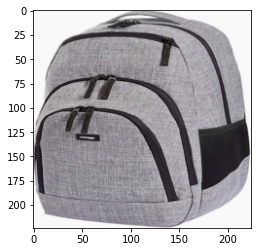

In [ ]:
denorm_image = denormalize(image0, *pi_stats)
plt.imshow(denorm_image.permute(1, 2, 0), cmap='gray')
print('Label:', p_ds.classes[label0])

Label: file cabinet


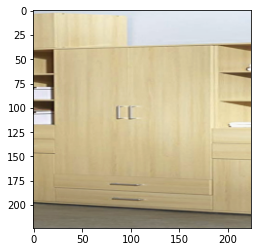

In [ ]:
denorm_image = denormalize(image1, *rw_stats)
plt.imshow(denorm_image.permute(1, 2, 0), cmap='gray')
print('Label:', rw_ds.classes[label1])

##Create DataLoaders

We'll create a function that splits our datasets into train and test. As the Assignment suggests, we'll make an 80-20% split of our datasets.

In [ ]:
def split_dl(ds, batch_size, test_pct=0.2):
  """
  This function creates train and test DataLoaders.

  """
  random_seed = 76 #random seed insures that we always get the same split so that we always train and test on the same images
  torch.manual_seed(random_seed)
  test_size = int(test_pct * len(ds))
  train_ds, test_ds = random_split(ds, [len(ds) - test_size, test_size])

  # PyTorch Data Loaders
  train_dl = DataLoader(train_ds, batch_size, shuffle=True)
  test_dl = DataLoader(test_ds, batch_size*2) #We're increasing the batch size since we only use the test dataloader in the evaluation that requires less computation (No grad)

  return train_dl, test_dl

# Using a GPU
Considering the sizes of the models and datasets, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. 

We can check if a GPU is available using `torch.cuda.is_available`.

In [ ]:
def get_default_device():
    """
    Pick GPU if available, else CPU
    
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function that can move data and model to a chosen device.

In [ ]:
def to_device(data, device):
    """
    Move tensors to chosen device
    
    """
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move batches of data to the selected device.

In [ ]:
class DeviceDataLoader():
    """
    Wrap a dataloader to move data to a device
    
    """
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) #The yield keyword in Python is used to create a generator function that can be used within a for loop,

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

#Optimizer
We'll create a function for the optimizer we'll be using in the training. Since we're using pre-trained models (AlexNet, ResNet18) we should apply a different learning rate to the frozen layers and the ones that will be trained from scratch (that requires a higher learning rate)

In [ ]:
def get_optimizer(model, lr, model_opt, opt, wd, momentum):
  """
   we will create two groups of weights, one for the newly initialized layer
   and the other for rest of the layers of the network

  """
  
  final_layer_weights = []
  rest_of_the_net_weights = []
  
  # iterate through the layers of the network 
  for name, param in model.named_parameters():
    if model_opt == 'alexnet':    #if the model we're using is alexnet
      if name.startswith('classifier.6'):
        final_layer_weights.append(param)
      else:
        rest_of_the_net_weights.append(param)
    elif model_opt == 'resnet18':   #if the model we're using is resnet18
      if name.startswith('fc'):
        final_layer_weights.append(param)
      else:
        rest_of_the_net_weights.append(param)

  # assign the distinct learning rates to each group of parameters
  if opt=='SGD':
    optimizer = torch.optim.SGD([
        {'params': rest_of_the_net_weights},
        {'params': final_layer_weights, 'lr': lr}
    ], lr=lr / 10, weight_decay=wd, momentum=momentum)
  elif opt=='Adam':
    optimizer = torch.optim.Adam([
        {'params': rest_of_the_net_weights},
        {'params': final_layer_weights, 'lr': lr}
    ], lr=lr / 10, weight_decay=wd)
  
  return optimizer

#Initialize Pre-Trained Models 
In this section, we'll create our model architecture. Since we have few samples to train on, it is preferable to use pre-trained models. We'll be using 2 pre-trained models: AlexNet then ResNet18.

###AlexNet Model Definiton
We'll be using AlexNet's architecture that consists of five convolutional layers with a combination of max pooling followed by 3 fully connected layers and they use Relu activation in each of these layers except the output layer. Furthermore, the model is trained on the Imagenet dataset which has almost 14 million images across a thousand classes. We'll load the trained weights and biases of all layers excepts the last fully connected layer.

We will adapt AlexNet to our task by creating a new function `initialize_alexnet` where we reinitialize the last layer of AlexNet.

In [ ]:
def initialize_alexnet(num_classes):

	# load the pre-trained Alexnet
	alexnet = torchvision.models.alexnet(pretrained=True)

	# get the number of neurons in the second last layer
	in_features = alexnet.classifier[6].in_features

	# re-initalize the output layer
	alexnet.classifier[6] = torch.nn.Linear(in_features=in_features, out_features=num_classes)
	alexnet.classifier[6].weight.data.normal_(0.0, 0.005) # initiliaze last fully connected layer weights according to the CORAL paper (N(0, 0.005))

	return alexnet

###ResNet18 Model Definition
We'll then experiment with the ResNet18's architecture that consists of 72-layer architecture with 18 deep layers.  
*ResNet* follows VGG’s full  convolutional layer design. The residual block has two  convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function.  
The architecture of this network aimed at enabling large amounts of convolutional layers to function efficiently.  
We'll load the trained weights and biases of all layers excepts the last fully connected layer.

We will adapt ResNet18 to our task by creating a new function `initialize_resnet18` where we reinitialize the last layer of ResNet18.

In [ ]:
def initialize_resnet18(num_classes):

  # load the pre-trained Alexnet
  resnet18 = torchvision.models.resnet18(pretrained=True)
  
  # get the number of neurons in the second last layer
  in_features = resnet18.fc.in_features
  
  # re-initalize the output layer
  resnet18.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes)
  resnet18.fc.weight.data.normal_(0.0, 0.005) # initiliaze last fully connected layer weights according to the CORAL paper (N(0, 0.005))
  
  return resnet18

#Source-Only Model Training and Testing
Here we'll create a function `training_step` that trains and `test_step` that tests our model and outputs the loss and accuracy cumulated after one epoch.

In [ ]:
def training_step(model, data_loader, optimizer):

  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # set the network to training mode: particularly important when using dropout!
  model.train() 

  # iterate over the training set
  for batch_idx in tnrange(len(data_loader)):

    data, labels = next(iter(data_loader))
      
    # forward pass
    outputs = model(data)

    # loss computation
    loss = F.cross_entropy(outputs,labels)

    # backward pass
    loss.backward()
    
    # parameters update
    optimizer.step()
    
    # gradients reset
    optimizer.zero_grad()

    # fetch prediction and loss value
    samples += data.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

    # compute training accuracy
    cumulative_accuracy += predicted.eq(labels).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

def test_step(model, data_loader):

  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # set the network to evaluation mode
  model.eval() 

  # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
  with torch.no_grad():

    # iterate over the test set
    for batch_idx, (data, labels) in enumerate(data_loader):
      
      # forward pass
      outputs = model(data)

      # loss computation
      loss = F.cross_entropy(outputs, labels)

      # fetch prediction and loss value
      samples+=data.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)

      # compute accuracy
      cumulative_accuracy += predicted.eq(labels).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

Finally, we create our `fit_source_only` model that trains and tests our model and outputs the results after each epoch. We'll contain these informations in a history list to create plots later on.

In [ ]:
def fit_source_only( model, epochs, s_train_loader, s_test_loader, t_test_loader, lr, weight_decay=0, model_opt = 'alexnet', opt='SGD', momentum=0 ):
  """
	This function trains and test the model. It outputs the results after each epoch.

	"""  
  so_history = []

  # choose optimizer depending on the model chosen
  optimizer = get_optimizer(model, lr, model_opt, opt, weight_decay, momentum)

  # perform a preliminar step
  print('Before training:')
  s_test_loss, s_test_accuracy = test_step(model,s_test_loader)
  t_test_loss, t_test_accuracy = test_step(model,t_test_loader)
  print('Epoch: {:d}'.format(0))
  print('\t Source Test loss {:.5f}, Source Test accuracy {:.2f}'.format(s_test_loss, s_test_accuracy))
  print('\t Target Test loss {:.5f}, Target Test accuracy {:.2f}'.format(t_test_loss, t_test_accuracy))
  print('-----------------------------------------------------------------------')
  so_history.append({
                'Source_Train': {'s_train_loss': 0, 's_train_acc': 0 },
                'Source_Test': {'s_test_loss': s_test_loss, 's_test_acc': s_test_accuracy }, 
                'Target_Test': {'t_test_loss': t_test_loss, 't_test_acc': t_test_accuracy }
                })

  # Test and Train for each epoch
  for epoch in range(epochs):
    train_loss, train_accuracy = training_step(model,s_train_loader, optimizer)
    s_test_loss, s_test_accuracy = test_step(model,s_test_loader)
    t_test_loss, t_test_accuracy = test_step(model,t_test_loader)

    # Print Results
    print('Epoch: {:d}'.format(epoch+1))
    print('\t Source Train loss {:.5f}, Source Train accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Source Test loss {:.5f}, Source Test accuracy {:.2f}'.format(s_test_loss, s_test_accuracy))
    print('\t Target Test loss {:.5f}, Target Test accuracy {:.2f}'.format(t_test_loss, t_test_accuracy))
    print('-----------------------------------------------------------------------')

    # Save history 
    so_history.append({'Source_Train': {'s_train_loss': train_loss, 's_train_acc': train_accuracy },
                    'Source_Test': {'s_test_loss': s_test_loss, 's_test_acc': s_test_accuracy },
                    'Target_Test': {'t_test_loss': t_test_loss, 't_test_acc': t_test_accuracy }
                    })

  return so_history

#Unsupervised Domain Adaptation Model: DeepCORAL
We finally reach our UDA part where we will adopt the [DeepCORAL](https://arxiv.org/pdf/1607.01719.pdf) method.

Unsupervised Domain Adaptation is used so that instead of collecting labelled data and training a new classifier for every possible scenario, UDA
methods try to compensate for the degradation in performance
by transferring knowledge from labelled source domains to unlabelled target domains.

Before DeepCORAL sees the light of the day, a previous research was established with the name of CORAL which aligns the second-order statistics
of the source and target distributions with a linear transformation. However, it relies on a linear transformation and is not end-to-end: it needs to
first extract features, apply the transformation, and then train an SVM classifier in a separate step.

As one might expect, DeepCORAL is an extension of CORAL which incorporates it directly into deep networks by constructing a differentiable loss function that minimizes the difference between source and target correlations: the CORAL loss.

Compared to CORAL, this approach learns a non-linear transformation that is more powerful and also works seamlessly with deep CNNs.




![image.png](https://ssarcandy.tw/img/2017-10-31/1.png) 

##Coral Loss Definition
The CORAL loss is defined as the distance between the second-order statistics
(covariances) of the source and target features:

##$$ \textit{l}_{CORAL} = \frac{1}{4d^{2}}||C_{S}-C_{T}||^{2}_{F}$$

where the norm is the squared matrix Frobenius. The covariance matrices of the source and target data are given by:



##$$ \textit{C}_{S} = \frac{1}{n_{S}-1}(D^{T}_{S}D_{S}-\frac{1}{n_{S}}(1^{T}D_{S})^{T}(1^{T}D_{S}))$$

##$$ \textit{C}_{T} = \frac{1}{n_{T}-1}(D^{T}_{T}D_{T}-\frac{1}{n_{T}}(1^{T}D_{T})^{T}(1^{T}D_{T}))$$

Minimizing the classification loss itself is likely to lead to overfitting to the source domain, causing reduced performance on the target domain. On the other hand, minimizing the CORAL loss alone might lead to degenerated features. For that reason, joint training with both the classification loss and CORAL loss is likely to learn features that work well on the target domain:

##$$ \textit{l} = \textit{l}_{CLASS} + \sum_{i=1}^t \lambda_{i} l_{CORAL} $$
In this section, we'll create a CORAL Loss Function based on the first and second equations shown below.  

Then we'll redefine our testing step and apply the total loss defined by the third equation in the training step function. We have to note that λ is a hyperparameter that controls the weight that trades off the adaptation with classification accuracy on the source domain. We'll implement it in a way after each epoch $ \lambda = \frac{epoch + 1}{\lambda} $ .
  
  These two losses play counterparts and reach an equilibrium at the end of training, where the final features are expected to work well on the target domain.




In [ ]:
def CORAL_loss(output_source, output_target):
  '''
  this function computes the CORAL loss as defined in the research paper

  '''
  d = output_source.size(1) # d-dimensional vectors (same for source, target = num_classes)
  source_covariance = batch_covariance(output_source)
  target_covariance = batch_covariance(output_target)
  loss = torch.norm(torch.mm((source_covariance-target_covariance),(source_covariance-target_covariance)), p="fro")
  loss = loss/(4*d*d)

  return loss

def batch_covariance(output):
  '''
  This function computes the covariance matrix as defined in the research paper

  '''
  n = output.size(0)                                                             #batch_size
  ones_vector = torch.ones(n).reshape(1, n).to(device=device)                    #1xbatch_size
  one_onto_D = torch.mm(ones_vector, output)                                     #1xnum_classes
  mult_right_terms = torch.mm(one_onto_D.t(), one_onto_D)                        #num_classesxnum_classes
  mult_right_terms = torch.div(mult_right_terms, n)                              #num_classesxnum_classes
  mult_left_terms = torch.mm(output.t(), output)                                 #num_classesxnum_classes
  covariance_matrix= 1/(n-1) * torch.add(mult_left_terms,-1*(mult_right_terms))  #num_classesxnum_classes

  return covariance_matrix

## DeepCORAL Model Training and Testing

Here we'll re-define our training step by implementing the DeepCORAL UDA method. Two Forward passes will be introduced one for the source and one for the target then a new loss will be computed using both the CrossEntropy for the classification loss and the CORAL loss.
As for the testing step, we'll retain the same one defined in the Source-Only Section.

In [ ]:
def coral_training_step(model, source_train, target_train, target_test, optimizer, lambda_factor):

  samples = 0.
  cumulative_class_loss = 0.
  cumulative_coral_loss = 0.
  cumulative_total_loss = 0.

  # set the network to training mode: particularly important when using dropout!
  model.train() 

  # iterate over the training set
  for batch_idx in tnrange(len(source_train)): #we can take either the source or target data as long as they have the same batch size

    # fetch data in batches
    source_data, source_label = next(iter(source_train)) 
    target_data, _ = next(iter(target_train)) # unsupervised learning  

    # forward pass
    output_source = model(source_data)
    output_target = model(target_data)

    # loss computations
    class_loss = F.cross_entropy(output_source, source_label)  # Calculate classification loss
    coral_loss = CORAL_loss(output_source, output_target) #Calculate CORAL loss
    total_loss = class_loss + lambda_factor*coral_loss #Total loss

    # backward pass
    total_loss.backward()
    
    # parameters update
    optimizer.step()
    
    # gradients reset
    optimizer.zero_grad()

    # fetch prediction and loss values
    samples += source_data.shape[0] #we can take either the source or target data as long as they have the same batch size
    cumulative_class_loss += class_loss.item()
    cumulative_coral_loss += coral_loss.item()
    cumulative_total_loss += total_loss.item()


  return cumulative_class_loss/samples, cumulative_coral_loss/samples,cumulative_total_loss/samples


Finally, we create our `fit_deep_coral` function that trains our model supervisedly on the source and unsupervisedly on the target and outputs the results after each epoch. We'll contain these informations in a history list to create plots later on.

In [ ]:
def fit_deep_coral( model, epochs, s_train_loader, s_test_loader, t_train_loader, t_test_loader, lr, weight_decay=0, model_opt= 'alexnet', opt='SGD', momentum=0 ):
  """
	This function trains and test the model. It outputs the results after each epoch.

	"""  
  uda_history = []

  # choose optimizer depending on the model chosen
  optimizer = get_optimizer(model,lr, model_opt, opt, weight_decay, momentum)
  
  # perform a preliminar step
  print('Before training:')
  t_test_loss, t_test_accuracy = test_step(model,t_test_loader)
  print('Epoch: {:d}'.format(0))
  print('\t Target Test loss {:.5f}, Target Test accuracy {:.2f}'.format(t_test_loss, t_test_accuracy))
  print('-----------------------------------------------------------------------')
  uda_history.append({
                      'Losses': {'class_loss': 0, 'coral_loss': 0, 'total_loss': 0 },
                      'Target_Test': {'t_test_loss': t_test_loss, 't_test_acc': t_test_accuracy }})

  # Test and Train for each epoch
  for epoch in range(epochs):
    lambda_factor = (epoch + 1) / epochs #Lambda factor hyperparameter changes after each epoch
    class_loss, coral_loss, total_loss = coral_training_step(model,s_train_loader, t_train_loader, t_test_loader, optimizer, lambda_factor)
    t_test_loss, t_test_accuracy = test_step(model,t_test_loader)

    # Print Results
    print('Epoch: {:d}'.format(epoch+1))
    print('\t Classification Loss {:.5f}, CORAL Loss {:.5f}, Classification Loss {:.5f}'.format(class_loss, coral_loss, total_loss))
    print('\t Target Test loss {:.5f}, Target Test accuracy {:.2f}'.format(t_test_loss, t_test_accuracy))
    print('-----------------------------------------------------------------------')

    # Save history 
    uda_history.append({'Losses': {'class_loss': class_loss, 'coral_loss': coral_loss, 'total_loss': total_loss },
                    'Target_Test': {'t_test_loss': t_test_loss, 't_test_acc': t_test_accuracy }
                    })

  return uda_history


#Models Initialization and Performance
In this section we will start training and testing our source-only and UDA models while changing each time the hyperparameters until we find the best results on our target loss and accuracy. 





We will also create two plot functions `plot_losses` and `plot_accuracies` to show the results of the different approaches and models.


In [ ]:
def plot_losses(so_history, uda_history):
  """
  This function plots the SO and UDA histories of the losses

  """
  so_loss = [x['Target_Test']['t_test_loss']  for x in so_history]
  s_loss = [x['Source_Test']['s_test_loss']  for x in so_history]
  t_loss = [x['Source_Train']['s_train_loss']  for x in so_history]
  uda_loss = [x['Target_Test']['t_test_loss']  for x in uda_history]

  plt.plot(t_loss, '-g')
  plt.plot(s_loss, '-r')
  plt.plot(so_loss, '-b')
  plt.plot(uda_loss, '-k')
  
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Source_Train', 'Source_Test', 'Target_Test ',  'UDA_Test'])
  plt.title('Loss vs. No. of epochs');

def plot_class_coral(uda_history):
  """
  This function plots the coral and classification losses

  """

  class_loss = [x['Losses']['class_loss']  for x in uda_history]
  coral_loss = [x['Losses']['coral_loss']  for x in uda_history]
  plt.plot(class_loss, '-b')
  plt.plot(coral_loss, '-r')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['class_loss ', 'coral_loss'])
  plt.title('Loss vs. No. of epochs');

def plot_accuracies(so_history, uda_history, ub_history):
  """
  This function plots the accuracies of SO and UDA.

  """
  ub_accuracy = [x['Source_Test']['s_test_acc'] for x in ub_history] #Upper Bound 
  plt.plot(ub_accuracy, '-g')
  uda_accuracy = [x['Target_Test']['t_test_acc'] for x in uda_history] #Target Test With UDA
  plt.plot(uda_accuracy, '-r')
  so_accuracy = [x['Target_Test']['t_test_acc'] for x in so_history] #Target Test Without UDA
  plt.plot(so_accuracy, '-b')
 
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['Upper Bound', 'DeepCORAL', 'Source Only'])
  plt.title('Accuracies vs. No. of epochs');

We'll also create two functions to save and load our histories in a pickle file.

In [ ]:
def save_log(obj, path):
	with open(path, 'wb') as f:
		pickle.dump(obj, f)
  
#insert your path below
def load_log(name):
  with open('{Project_Path}//History_logs/{}.pickle'.format(name), 'rb') as f: #Insert here the path where you have your logs saved (e.g {your_path}/History_Logs)
    x = pickle.load(f)
  return x

Now, we'll create our DataLoaders and models and move them to the GPU.

In [ ]:
#Split Datasets into Train and Test
p_train, p_test = split_dl(p_ds, 64)       # Product Domain dataloaders
rw_train, rw_test = split_dl(rw_ds, 64)    # Real World Domain dataloaders 

#Move DataLoaders to GPU
p_train = DeviceDataLoader(p_train, device)
p_test = DeviceDataLoader(p_test, device)
rw_train = DeviceDataLoader(rw_train, device)
rw_test = DeviceDataLoader(rw_test, device)

#Initialize models and move to GPU
alexnet = initialize_alexnet(num_classes=20).to(device)
resnet18 = initialize_resnet18(num_classes=20).to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

##Trainings

For clarity of the project, we will only display the best hyperparameters we got for each model train.

###AlexNet Source-Only/UDA Performance (Product > Real Life)

In [ ]:
model_opt = 'alexnet'
opt='SGD'
epochs = 50
weight_decay = 0.0005
momentum = 0.9
lr = 0.001

alex_so_history = fit_source_only( alexnet, epochs, p_train, p_test, rw_test, lr, weight_decay, model_opt, opt, momentum )

In [ ]:
#save_log(alex_so_history,'{Project_Path}/History_logs/alex_so_history.pickle')

In [ ]:
model_opt = 'alexnet'  
opt='SGD'  
epochs = 50  
weight_decay = 0.0005
momentum = 0.9
lr = 0.001

alex_uda_history = fit_deep_coral( alexnet, epochs, p_train, p_test, rw_train, rw_test, lr, weight_decay, model_opt, opt, momentum )

In [ ]:
#save_log(alex_uda_history,'{Project_Path}/History_logs/alex_uda_history.pickle')

In [ ]:
alex_so_history = load_log('alex_so_history')
alex_uda_history = load_log('alex_uda_history')

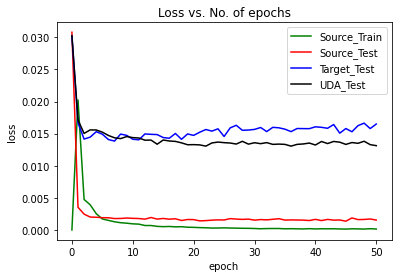

In [ ]:
plot_losses(alex_so_history, alex_uda_history)

###AlexNet Source-Only/UDA Performance (Real Life > Product)

In [ ]:
model_opt = 'alexnet'
opt='SGD'
epochs = 50
weight_decay = 0.0005
momentum = 0.9
lr = 0.001

alex_so_history_od = fit_source_only( alexnet, epochs, rw_train, rw_test, p_test, lr, weight_decay, model_opt, opt, momentum )

In [ ]:
#save_log(alex_so_history_od,'{Project_Path}/History_logs/alex_so_history_od.pickle')

In [ ]:
model_opt = 'alexnet'
opt='SGD'
epochs = 50
weight_decay = 0.0005
momentum = 0.9
lr = 0.001

alex_uda_history_od = fit_deep_coral( alexnet, epochs, rw_train, rw_test, p_train, p_test, lr, weight_decay,  model_opt , opt, momentum )

In [ ]:
#save_log(alex_uda_history_od,'{Project_Path}/History_logs/alex_uda_history_od.pickle')

In [ ]:
alex_so_history_od = load_log('alex_so_history_od')
alex_uda_history_od = load_log('alex_uda_history_od')

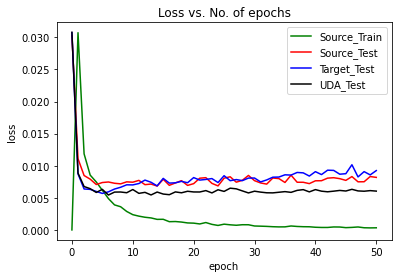

In [ ]:
plot_losses(alex_so_history_od, alex_uda_history_od)

###ResNet18 Source-Only/UDA Performance (Product > Real Life)

In [ ]:
model_opt = 'resnet18'
opt='Adam'
epochs = 100
weight_decay = 0.0005
lr = 0.0005

resnet_so_history = fit_source_only( resnet18, epochs, p_train, p_test, rw_test, lr, weight_decay, model_opt, opt)

In [ ]:
#save_log(resnet_so_history,'{Project_Path}/History_logs/resnet_so_history.pickle')

In [ ]:
model_opt = 'resnet18'
opt='Adam'
epochs = 80
weight_decay = 0.0005
lr = 0.0005

resnet_uda_history = fit_deep_coral( resnet18, epochs, p_train, p_test,rw_train, rw_test, lr, weight_decay ,  model_opt , opt)

In [ ]:
#save_log(resnet_uda_history,'{Project_Path}/History_logs/resnet_uda_history.pickle')

In [ ]:
resnet_so_history = load_log('resnet_so_history')
resnet_uda_history = load_log('resnet_uda_history')

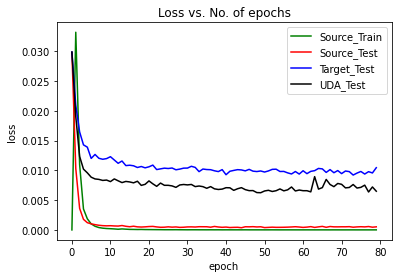

In [ ]:
plot_losses(resnet_so_history[0:80], resnet_uda_history[0:80]) 

###ResNet18 Source-Only/UDA Performance ( Real Life > Product)

In [ ]:
model_opt = 'resnet18'
opt='Adam'
epochs = 100
weight_decay = 0.0005
lr = 0.0005

resnet_so_history_od = fit_source_only( resnet18, epochs, rw_train, rw_test, p_test, lr, weight_decay , model_opt, opt)

In [ ]:
#save_log(resnet_so_history_od,'{Project_Path}/History_logs/resnet_so_history_od.pickle')

In [ ]:
model_opt = 'resnet18'
opt='Adam'
epochs = 100
weight_decay = 0.0005
lr = 0.001

resnet_uda_history_od = fit_deep_coral( resnet18, epochs, rw_train, rw_test, p_train, p_test, lr, weight_decay ,  model_opt , opt)

In [ ]:
#save_log(resnet_uda_history_od,'{Project_Path}/History_logs/resnet_uda_history_od.pickle')

In [ ]:
resnet_so_history_od = load_log('resnet_so_history_od')
resnet_uda_history_od = load_log('resnet_uda_history_od')

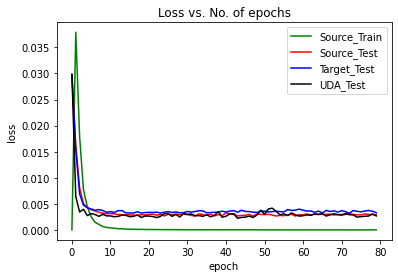

In [ ]:
plot_losses(resnet_so_history_od[0:80], resnet_uda_history_od[0:80])

#Conclusion
In this section we will only retain the ResNet18 model since it outperformed AlexNet using Adam that performed better than SGD+Momentum.




To give a generalized result of the accuracy, we took the mean over the results starting from the 20th (when the model's performance gets stable) epoch until the end (80 epochs)

In [ ]:
def get_accuracy_mean(data):
  """
  This function computes the accuracy by mean.

  """
  val = [x['Target_Test']['t_test_acc'] for x in data]
  x = statistics.mean(val)
  return x

In [ ]:
acc_so = get_accuracy_mean(resnet_so_history[19:-1])
acc_uda = get_accuracy_mean(resnet_uda_history[19:-1])
acc_so_od = get_accuracy_mean(resnet_so_history_od[19:-1])
acc_uda_od = get_accuracy_mean(resnet_uda_history_od[19:-1])
table_avg = [['Version', 'P-->RW', 'RW-->P'], 
         ['Source Only', acc_so, acc_so_od], 
         ['DA', acc_uda, acc_uda_od],
         ['GAIN', acc_uda-acc_so, acc_uda_od-acc_so_od]]
print(tabulate(table_avg, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤══════════╤══════════╕
│ Version     │   P-->RW │   RW-->P │
╞═════════════╪══════════╪══════════╡
│ Source Only │  66.9753 │ 87.7191  │
├─────────────┼──────────┼──────────┤
│ DA          │  80.0861 │ 90.8811  │
├─────────────┼──────────┼──────────┤
│ GAIN        │  13.1108 │  3.16201 │
╘═════════════╧══════════╧══════════╛


Note: By using the Maximum Accuracy achieved by the model instead of the Mean Accuracy, we would get these results:


In [ ]:
acc_so = max([x['Target_Test']['t_test_acc'] for x in resnet_so_history[19:-1]])
acc_uda = max([x['Target_Test']['t_test_acc'] for x in resnet_uda_history[19:-1]])
acc_so_od = max([x['Target_Test']['t_test_acc'] for x in resnet_so_history_od[19:-1]])
acc_uda_od = max([x['Target_Test']['t_test_acc'] for x in resnet_uda_history_od[19:-1]])
table_max = [['Version', 'P-->RW', 'RW-->P'], 
         ['Source Only', acc_so, acc_so_od], 
         ['DA', acc_uda, acc_uda_od],
         ['GAIN', acc_uda-acc_so, acc_uda_od-acc_so_od]]
print(tabulate(table_max, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤══════════╤══════════╕
│ Version     │   P-->RW │   RW-->P │
╞═════════════╪══════════╪══════════╡
│ Source Only │    71.25 │    89.25 │
├─────────────┼──────────┼──────────┤
│ DA          │    83    │    93.25 │
├─────────────┼──────────┼──────────┤
│ GAIN        │    11.75 │     4    │
╘═════════════╧══════════╧══════════╛


We'll plot the accuracies to see our model resides between the minimum bound (Real Life Test on Source Only of Product) and the Upper Bound (Real Life Test on Source Only of Real Life).

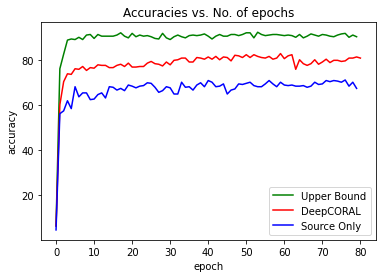

In [ ]:
plot_accuracies(resnet_so_history[0:80], resnet_uda_history, resnet_so_history_od[0:80])

We'll plot the accuracies to see our model resides between the minimum bound (Product Test on Source Only of Real Life) and the Upper Bound (Product Test on Source Only of Product).

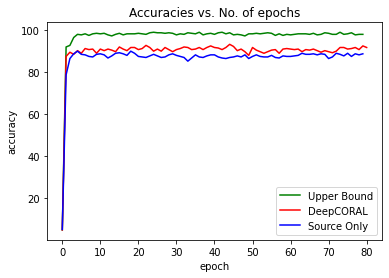

In [ ]:
plot_accuracies(resnet_so_history_od[0:80], resnet_uda_history_od, resnet_so_history[0:80])

As written in the paper, in the beginning the CORAL loss is very small while the
classification loss is very large. After training for a few iterations, these
two losses are about the same.

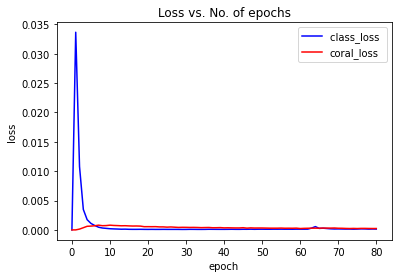

In [ ]:
plot_class_coral(resnet_uda_history)

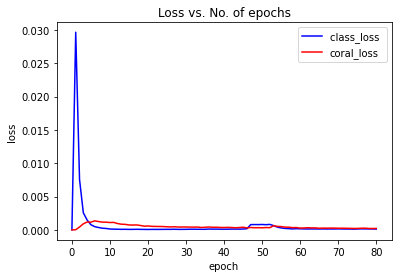

In [ ]:
plot_class_coral(resnet_uda_history_od)

#Links and References

[DeepCORAL: Correlation Alignment for Deep Domain Adaptation](https://arxiv.org/pdf/1607.01719.pdf)

[Deep Domain Adaptation in Computer Vision](https://towardsdatascience.com/deep-domain-adaptation-in-computer-vision-8da398d3167f)

[AlexNet Architecture Explained](https://medium.com/analytics-vidhya/alexnet-architecture-explained-5d19e3dca2bb)

[An Overview of ResNet and its Variants](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)

[A 2021 Guide to improving CNNs-Optimizers: Adam vs SGD](https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008)

[Understand the Dynamics of Learning rate on Deep Learning Neural Networks](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)

[Why 0.9? Towards Better Momentum Strategies in Deep Learning.](https://towardsdatascience.com/why-0-9-towards-better-momentum-strategies-in-deep-learning-827408503650#:~:text=In%20deep%20learning%2C%20most%20practitioners,many%20popular%20deep%20learning%20packages)

[How to Use Weight Decay to Reduce Overfitting](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/)








